# FENE beadspring with variable kuhn length experiment data analysis

In [3]:
import os

import polyflexmd.data_analysis.data.read as read
import polyflexmd.data_analysis.transform.transform as transform
import polyflexmd.data_analysis.theory.kremer_grest as kremer_grest
import polyflexmd.data_analysis.theory.rouse as rouse
import polyflexmd.data_analysis.plot.plot_system as plot_system
import polyflexmd.data_analysis.data.constants as data_constants
import polyflexmd.data_analysis.pipelines.process as pipeline_process
import polyflexmd.experiment_runner.config as config
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from pandarallel import pandarallel
import seaborn as sns
import scipy.optimize
import functools

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
sns.set_style("darkgrid")

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


## Read and process data

In [34]:
PATH_EXPERIMENT = "/scratch/ws/0/s4610340-bt-eea1-md-workspace/data/experiment_results/FENE-beadspring-vary-l_K/12-EEA1_short-long_time/7ded95ff"
NAME_EC = "12-EEA1_short-long_time.toml"
EQUILIBRIUM_ONLY = True
CONTINUE = False
CONTINUE_t_equilibrium = 58000000
N_WORKERS = 16
CHECK_BOND_LENGTHS = False

In [111]:
CONTINUE = bool(CONTINUE)
CONTINUE_t_equilibrium = int(CONTINUE_t_equilibrium)
EQUILIBRIUM_ONLY = bool(EQUILIBRIUM_ONLY)
CHECK_BOND_LENGTHS = bool(CHECK_BOND_LENGTHS)
PATH_EXPERIMENT = pathlib.Path(PATH_EXPERIMENT)
PATH_SYSTEM_DEF = PATH_EXPERIMENT / "data/initial_system.data"
PATH_EC = PATH_EXPERIMENT / NAME_EC
N_WORKERS = int(N_WORKERS)

In [112]:
pandarallel.initialize(
    nb_workers=N_WORKERS,
    progress_bar=False,
    use_memory_fs=None
)

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


### Read experiment config

In [37]:
conf = config.read_experiment_config(PATH_EC)
conf

ExperimentConfig(simulation_config=SimulationConfig(job=SlurmJobConfig(account='p_mdpolymer', time='144:00:00', partition='romeo', nodes=1, tasks_per_node=125, ntasks=125, cpus_per_task=1, mem_per_cpu=1000), lammps_executable='/scratch/ws/0/s4610340-bt-eea1-md-workspace/bin/lammps-patch_23Jun2022_update4/lmp_omp_romeo_opt', lmod_modules='modenv/hiera GCC/11.3.0 OpenMPI/4.1.4 Python/3.9.6', simulation_model_path=PosixPath('simulations/FENE-beadspring-vary-l_K.lammps'), experiments_path=PosixPath('/scratch/ws/0/s4610340-bt-eea1-md-workspace/data/experiment_results'), n_partitions=1, n_tasks_per_partition=125, variables={'kappa_start': 190.2, 'kappa_delta': 0.0, 'kappa_n_values': 1, 'n_relax_steps': 35000000, 'n_equilibrium_steps': 500000000}), initial_system_config=SystemCreatorConfig(system_type='create', job=SlurmJobConfig(account='p_mdpolymer', time='1:00:00', partition='romeo', nodes=1, tasks_per_node=1, ntasks=1, cpus_per_task=2, mem_per_cpu=2000), venv_path=PosixPath('/scratch/ws/0

In [38]:
kappas: list[float] = [
    conf.simulation_config.variables["kappa_start"] + conf.simulation_config.variables["kappa_delta"] * i
    for i in range(conf.simulation_config.variables["kappa_n_values"])
]
kappas

[190.2]

### Read initial system

In [39]:
system = read.read_lammps_system_data(PATH_SYSTEM_DEF)
system.atoms

,molecule-ID,type,x,y,z,ix,iy,iz
1,1,1,0.000000,0.000000,0.000000,0,0,0
2,1,1,-0.336178,0.186169,0.890632,0,0,0
3,1,2,-0.672356,0.372339,1.781264,0,0,0
4,1,2,-1.008534,0.558508,2.671896,0,0,0
5,1,2,-1.344712,0.744678,3.562528,0,0,0
...,...,...,...,...,...,...,...,...
3196,50,2,-33.296599,35.971466,-29.540870,0,0,0
3197,50,2,-33.860948,36.581152,-30.041563,0,0,0
3198,50,2,-34.425297,37.190838,-30.542256,0,0,0
3199,50,2,-34.989646,37.800524,-31.042949,0,0,0


In [40]:
system.bonds

,type,atom1,atom2
1,1,1,2
2,1,2,3
3,1,3,4
4,1,4,5
5,1,5,6
...,...,...,...
3146,1,3195,3196
3147,1,3196,3197
3148,1,3197,3198
3149,1,3198,3199


In [41]:
system.angles

,type,atom1,atom2,atom3
1,1,1,2,3
2,1,2,3,4
3,1,3,4,5
4,1,4,5,6
5,1,5,6,7
...,...,...,...,...
3096,1,3194,3195,3196
3097,1,3195,3196,3197
3098,1,3196,3197,3198
3099,1,3197,3198,3199


In [42]:
system.box

-100.000000 100.000000  xlo xhi
-100.000000 100.000000  ylo yhi
-100.000000 100.000000  zlo zhi

### Extract main-axis dataframe

In [43]:
PATH_DATA_PROCESSED = PATH_EXPERIMENT / "data" / "processed"
if CONTINUE:
    PATH_DATA_PROCESSED = PATH_DATA_PROCESSED / "continue"
PATH_DATA_PROCESSED.mkdir(exist_ok=True, parents=True)
PATH_DATA_PROCESSED

PosixPath('/scratch/ws/0/s4610340-bt-eea1-md-workspace/data/experiment_results/FENE-beadspring-vary-l_K/12-EEA1_short-long_time/7ded95ff/data/processed')

In [44]:
PATH_DF_MAIN_AXIS = PATH_DATA_PROCESSED / "main_axis.csv"
if PATH_DF_MAIN_AXIS.exists():
    df_main_axis = pd.read_csv(PATH_DF_MAIN_AXIS)
else:
    df_main_axis = transform.unfold_coordinates_df(system.atoms, system).groupby("molecule-ID").head(n=2)
    df_main_axis.to_csv(PATH_DF_MAIN_AXIS, index=False)
df_main_axis

,molecule-ID,type,x,y,z,ix,iy,iz
0,1,1,0.000000,0.000000,0.000000,0,0,0
1,1,1,-0.336178,0.186169,0.890632,0,0,0
2,2,1,0.000000,0.000000,0.000000,0,0,0
3,2,1,-0.272215,-0.119898,0.923268,0,0,0
4,3,1,0.000000,0.000000,0.000000,0,0,0
...,...,...,...,...,...,...,...,...
95,48,1,-0.624500,0.282755,0.686257,0,0,0
96,49,1,0.000000,0.000000,0.000000,0,0,0
97,49,1,0.175656,-0.067861,0.951546,0,0,0
98,50,1,0.000000,0.000000,0.000000,0,0,0


### Read and process trajectories

In [45]:
PATH_DF_TRAJECTORY_PROCESSED = PATH_DATA_PROCESSED / "trajectories.csv"
PATH_DF_TRAJECTORY_PROCESSED

PosixPath('/scratch/ws/0/s4610340-bt-eea1-md-workspace/data/experiment_results/FENE-beadspring-vary-l_K/12-EEA1_short-long_time/7ded95ff/data/processed/trajectories.csv')

In [46]:
if PATH_DF_TRAJECTORY_PROCESSED.exists():
    print("Reading processed...")
    df_trajectory_unfolded_kappas = pd.read_csv(
        PATH_DF_TRAJECTORY_PROCESSED,
        dtype={
            **data_constants.RAW_TRAJECTORY_DF_COLUMN_TYPES,
            "molecule-ID": np.ushort,
            "kappa": "category",
        }
    )
else:
    print("Reading and processing...")
    df_trajectory_unfolded_kappas = pipeline_process.read_and_process_trajectories(
        trajectories=read.get_experiment_trajectories_paths(
            experiment_raw_data_path=PATH_EXPERIMENT / "data",
            style="l_K",
            kappas=kappas,
            continue_=CONTINUE,
            read_relax=not EQUILIBRIUM_ONLY
        ),
        system=system
    )
    print("Writing...")
    df_trajectory_unfolded_kappas.to_csv(PATH_DF_TRAJECTORY_PROCESSED, index=False)

df_trajectory_unfolded_kappas

Reading processed...


,t,id,type,x,y,z,molecule-ID,kappa
0,35000000,1,1,0.000000,0.000000,0.000000,1,190.2
1,35000000,2,1,-0.336178,0.186169,0.890632,1,190.2
2,35000000,3,2,-0.714131,0.315115,1.827460,1,190.2
3,35000000,4,2,-1.036140,0.437473,2.704180,1,190.2
4,35000000,5,2,-1.264000,0.580728,3.682480,1,190.2
...,...,...,...,...,...,...,...,...
160003195,535000000,3196,2,-16.042000,33.235500,-39.390400,50,190.2
160003196,535000000,3197,2,-15.760300,33.960800,-39.969100,50,190.2
160003197,535000000,3198,2,-15.532800,34.590300,-40.663100,50,190.2
160003198,535000000,3199,2,-15.251300,35.347000,-41.266500,50,190.2


In [47]:
df_trajectory_unfolded_kappas.groupby(["kappa"])["t"].describe()

,count,mean,std,min,25%,50%,75%,max
kappa,,,,,,,,
190.2,160003200.0,285000000.0,1.443405e+08,35000000.0,160000000.0,285000000.0,410000000.0,535000000.0


## Calculate and plot observables relax+equi

In [48]:
l_b_src = .97
L_src = l_b_src*(conf.initial_system_config.system_config.n_monomers-1)
L_src

61.11

### End-to-End distance $\vec{R}$

In [49]:
PATH_ETE = PATH_DATA_PROCESSED / "ete.csv"

if PATH_ETE.exists():
    print("Reading processed...")
    df_ete = pd.read_csv(PATH_ETE, index_col=["kappa", "molecule-ID", "t"])
else:
    print("Processing...")
    df_ete = transform.calc_end_to_end_df(df_trajectory_unfolded_kappas, group_by_params=["kappa"], parallel=True)
    print("Writing...")
    df_ete.to_csv(PATH_ETE, index=True)

df_ete

Reading processed...


R_x       R_y      R_z          R
kappa molecule-ID t                                               
190.2 1           35000000  -11.2090 -18.61880  54.2396  58.431461
                  35010000  -12.1431 -15.40350  54.8017  58.206091
                  35020000  -10.6825 -10.82600  57.7616  59.730399
                  35030000  -11.9759 -11.76350  56.9861  59.407219
                  35040000  -11.4731  -7.79221  57.9553  59.591672
...                              ...       ...      ...        ...
      50          534960000 -21.5631  36.43180 -43.0082  60.348559
                  534970000 -21.3312  34.18480 -44.2859  59.873714
                  534980000 -21.5255  33.97930 -44.6883  60.124738
                  534990000 -14.1611  37.88690 -41.9876  58.300193
                  535000000 -14.9624  36.15070 -41.7827  57.241074

[2500050 rows x 4 columns]

In [50]:
df_ete["t/LJ"] = df_ete.index.get_level_values("t").map(lambda x: x * 0.0025)
df_ete["R^2"] = df_ete["R"] ** 2
df_ete

R_x       R_y      R_z          R       t/LJ  \
kappa molecule-ID t                                                             
190.2 1           35000000  -11.2090 -18.61880  54.2396  58.431461    87500.0   
                  35010000  -12.1431 -15.40350  54.8017  58.206091    87525.0   
                  35020000  -10.6825 -10.82600  57.7616  59.730399    87550.0   
                  35030000  -11.9759 -11.76350  56.9861  59.407219    87575.0   
                  35040000  -11.4731  -7.79221  57.9553  59.591672    87600.0   
...                              ...       ...      ...        ...        ...   
      50          534960000 -21.5631  36.43180 -43.0082  60.348559  1337400.0   
                  534970000 -21.3312  34.18480 -44.2859  59.873714  1337425.0   
                  534980000 -21.5255  33.97930 -44.6883  60.124738  1337450.0   
                  534990000 -14.1611  37.88690 -41.9876  58.300193  1337475.0   
                  535000000 -14.9624  36.15070 -41.7827  57.241074  1337500.0   

                                     R^2  
kappa molecule-ID t                       
190.2 1           35000000   3414.235603  
                  35010000   3387.949013  
                  35020000   3567.720517  
                  35030000   3529.217706  
                  35040000   3551.167358  
...                                  ...  
      50          534960000  3641.948600  
                  534970000  3584.861583  
                  534980000  3614.984136  
                  534990000  3398.912499  
                  535000000  3276.540544  

[2500050 rows x 6 columns]

In [51]:
df_ete_mean = df_ete.groupby(["kappa", "t"])[["R^2"]].mean()
df_ete_mean["l_K"] = kremer_grest.bare_kuhn_length(
    np.array(df_ete_mean.index.get_level_values("kappa")),
    l_b=l_b_src
)
df_ete_mean

R^2      l_K
kappa t                              
190.2 35000000   3330.423988  368.018
      35010000   3310.485075  368.018
      35020000   3328.628641  368.018
      35030000   3347.597465  368.018
      35040000   3373.031289  368.018
...                      ...      ...
      534960000  3352.726016  368.018
      534970000  3356.952683  368.018
      534980000  3347.940092  368.018
      534990000  3344.046056  368.018
      535000000  3319.040902  368.018

[50001 rows x 2 columns]

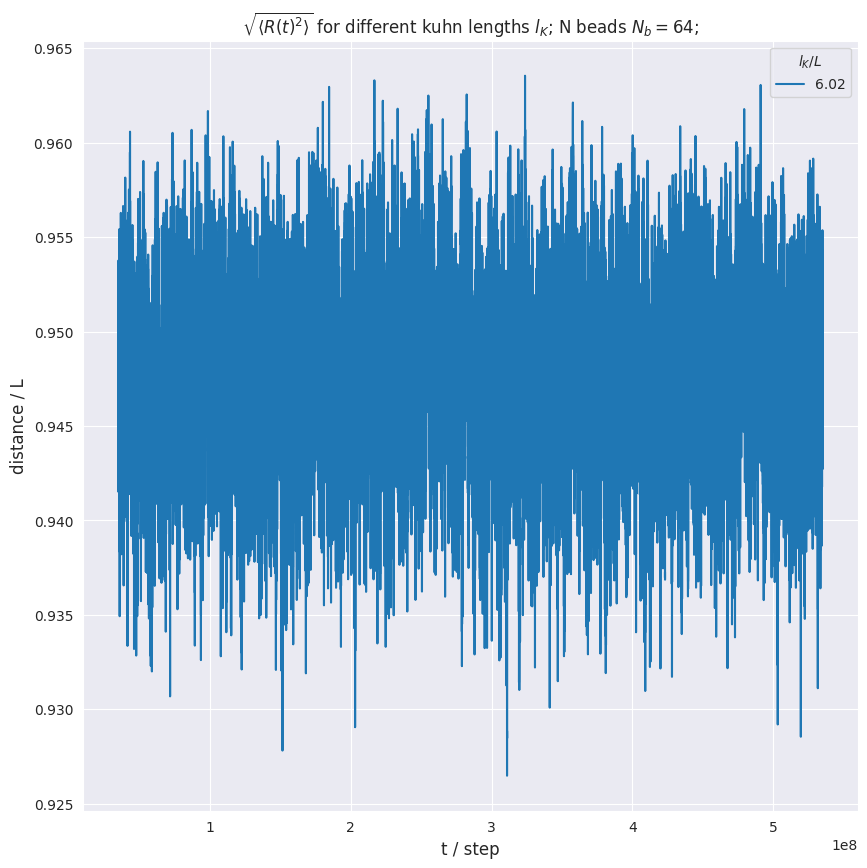

In [52]:
kappa_colors = sns.color_palette(n_colors=len(kappas))

ax: plt.Axes
fig: plt.Figure
fig, ax = plt.subplots(figsize=(10,10))
ax.set(
    title=f'$\sqrt{{\\langle R(t)^2 \\rangle }}$ for different kuhn lengths $l_K$; '
          f'N beads $N_b={conf.initial_system_config.system_config.n_monomers}$;',
    ylabel="distance / L",
    xlabel="t / step"
)

sns.lineplot(
    x=df_ete_mean.index.get_level_values("t"),
    y=np.sqrt(df_ete_mean["R^2"]) / L_src,
    hue=(df_ete_mean["l_K"]/L_src).round(2).astype("category"),
    color=kappa_colors,
    ax=ax
)

ax.get_legend().set_title("$l_K/L$")

## Equilibrium statistics

In [53]:
t_equilibrium = conf.simulation_config.variables["n_relax_steps"] if not CONTINUE else CONTINUE_t_equilibrium
t_equilibrium

35000000

In [54]:
df_trajectory_unfolded_kappas_equi = df_trajectory_unfolded_kappas.loc[df_trajectory_unfolded_kappas["t"] > t_equilibrium]
df_trajectory_unfolded_kappas_equi

,t,id,type,x,y,z,molecule-ID,kappa
3200,35010000,1,1,0.000000,0.000000,0.000000,1,190.2
3201,35010000,2,1,-0.336178,0.186169,0.890632,1,190.2
3202,35010000,3,2,-0.581648,0.278742,1.762590,1,190.2
3203,35010000,4,2,-0.869064,0.318068,2.717560,1,190.2
3204,35010000,5,2,-1.131940,0.420708,3.620820,1,190.2
...,...,...,...,...,...,...,...,...
160003195,535000000,3196,2,-16.042000,33.235500,-39.390400,50,190.2
160003196,535000000,3197,2,-15.760300,33.960800,-39.969100,50,190.2
160003197,535000000,3198,2,-15.532800,34.590300,-40.663100,50,190.2
160003198,535000000,3199,2,-15.251300,35.347000,-41.266500,50,190.2


In [55]:
df_ete_kappas_equi = df_ete.iloc[df_ete.index.get_level_values("t") >= t_equilibrium]
df_ete_kappas_equi

R_x       R_y      R_z          R       t/LJ  \
kappa molecule-ID t                                                             
190.2 1           35000000  -11.2090 -18.61880  54.2396  58.431461    87500.0   
                  35010000  -12.1431 -15.40350  54.8017  58.206091    87525.0   
                  35020000  -10.6825 -10.82600  57.7616  59.730399    87550.0   
                  35030000  -11.9759 -11.76350  56.9861  59.407219    87575.0   
                  35040000  -11.4731  -7.79221  57.9553  59.591672    87600.0   
...                              ...       ...      ...        ...        ...   
      50          534960000 -21.5631  36.43180 -43.0082  60.348559  1337400.0   
                  534970000 -21.3312  34.18480 -44.2859  59.873714  1337425.0   
                  534980000 -21.5255  33.97930 -44.6883  60.124738  1337450.0   
                  534990000 -14.1611  37.88690 -41.9876  58.300193  1337475.0   
                  535000000 -14.9624  36.15070 -41.7827  57.241074  1337500.0   

                                     R^2  
kappa molecule-ID t                       
190.2 1           35000000   3414.235603  
                  35010000   3387.949013  
                  35020000   3567.720517  
                  35030000   3529.217706  
                  35040000   3551.167358  
...                                  ...  
      50          534960000  3641.948600  
                  534970000  3584.861583  
                  534980000  3614.984136  
                  534990000  3398.912499  
                  535000000  3276.540544  

[2500050 rows x 6 columns]

In [56]:
df_ete_mean_equi = df_ete_mean.iloc[df_ete_mean.index.get_level_values("t") > t_equilibrium]
df_ete_mean_equi

R^2      l_K
kappa t                              
190.2 35010000   3310.485075  368.018
      35020000   3328.628641  368.018
      35030000   3347.597465  368.018
      35040000   3373.031289  368.018
      35050000   3355.977606  368.018
...                      ...      ...
      534960000  3352.726016  368.018
      534970000  3356.952683  368.018
      534980000  3347.940092  368.018
      534990000  3344.046056  368.018
      535000000  3319.040902  368.018

[50000 rows x 2 columns]

### Mean bond length

In [61]:
if CHECK_BOND_LENGTHS:
    l_b_df = transform.extract_bond_lengths_df_kappas(df_trajectory_unfolded_kappas_equi, t_equilibrium=t_equilibrium)
    print(l_b_df.groupby("kappa").describe())

In [62]:
l_b = conf.initial_system_config.system_config.bond_length
l_b

0.97

### Mean contour length

In [63]:
L_contour = l_b*(conf.initial_system_config.system_config.n_monomers-1)
L_contour

61.11

### Kuhn lengths

Svaneborg (8)

In [64]:
l_ks = kremer_grest.bare_kuhn_length(np.array(kappas), l_b)
l_ks

array([368.018])

Estimate from fit (Worm-like chain model, Hinczewski):

In [65]:
l_ks_estimate = transform.estimate_kuhn_length_df(
    df_trajectory_unfolded_kappas_equi,
    group_by_params=["kappa"]
)
l_ks_estimate

,l_K,d_l_K
kappa,,
190.2,379.593224,0.012087


In [66]:
l_ks_estimate / L_contour

,l_K,d_l_K
kappa,,
190.2,6.211638,0.000198


Difference of analytical l_K and estimated l_K relative to analytical l_K

In [67]:
np.abs(l_ks - l_ks_estimate["l_K"]) / l_ks

kappa
190.2    0.031453
Name: l_K, dtype: float64

### Number of Kuhn segments $N_K$

Estimate $N_K = L / l_K$ as in Svaneborg (6)

In [68]:
N_Ks = (L_contour / l_ks)
N_Ks

array([0.16605166])

### End-to-End distance squared $\langle R^2 \rangle$

Estimate $\langle R^2 \rangle$ as average over ensemble and then over time in equilibrium

In [69]:
df_ete_sq_t_mean_kappas = transform.calculate_ete_sq_t_avg_df_kappas(df_ete_mean_equi, t_equilibrium)
df_ete_sq_t_mean_kappas

,R^2
kappa,
190.2,3354.509974


### Summarize statistics by kappas

In [70]:
df_kuhn_summary = pd.DataFrame({
    "R^2": df_ete_sq_t_mean_kappas["R^2"],
    "N_K": N_Ks,
    "l_K": l_ks
}, index=df_ete_sq_t_mean_kappas.index)
df_kuhn_summary

,R^2,N_K,l_K
kappa,,,
190.2,3354.509974,0.166052,368.018


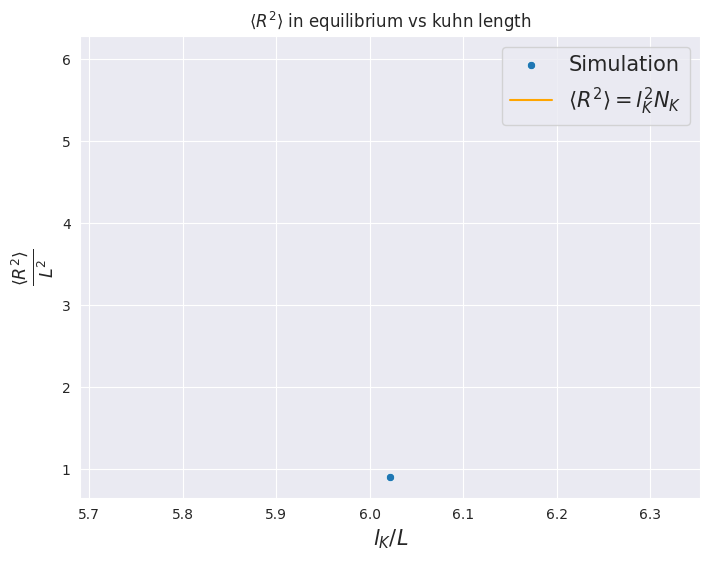

In [71]:
fig, ax = plt.subplots(figsize=(8,6))

sns.scatterplot(
    x=df_kuhn_summary["l_K"]/L_contour,
    y=df_kuhn_summary["R^2"]/L_contour**2,
    ax=ax,
    label="Simulation"
)

sns.lineplot(
    x=df_kuhn_summary["l_K"]/L_contour,
    y=(df_kuhn_summary["l_K"]**2 * N_Ks) / L_contour**2,
    label=r"$\langle R^2 \rangle = l_K^2 N_K$",
    color="orange"
)

ax.set(
    title=r"$\langle R^2 \rangle$ in equilibrium vs kuhn length",
    xlabel="$l_K / L$",
    ylabel=r"$\frac{\langle R^2 \rangle}{L^2}$"
)

ax.legend(fontsize=15)
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(18)

In [72]:
df_kuhn_summary["l_K"]**2 * df_kuhn_summary["N_K"] / df_kuhn_summary["R^2"]

kappa
190.2    6.704282
dtype: float64

### ETE change $ \langle (\Delta R(t))^2 \rangle $

In [74]:
PATH_DF_MSD = PATH_DATA_PROCESSED / "msd.csv"
PATH_DF_MSD

PosixPath('/scratch/ws/0/s4610340-bt-eea1-md-workspace/data/experiment_results/FENE-beadspring-vary-l_K/12-EEA1_short-long_time/7ded95ff/data/processed/msd.csv')

In [85]:
if PATH_DF_MSD.exists():
    print("Reading processed ...")
    df_ete_change_kappas_equi = pd.read_csv(PATH_DF_MSD, index_col="t")
else:
    print("Processing ...")
    df_ete_change_kappas_equi = transform.calculate_ens_avg_df_ete_change_kappas(df_ete_kappas_equi)
    df_ete_change_kappas_equi["l_K"] = kremer_grest.bare_kuhn_length(df_ete_change_kappas_equi["kappa"], l_b=l_b)
    df_ete_change_kappas_equi["t/LJ"] = df_ete_change_kappas_equi.index.get_level_values("t").map(lambda t: t*0.0025)
    df_ete_change_kappas_equi["t/LJ"] = df_ete_change_kappas_equi["t/LJ"]-df_ete_change_kappas_equi["t/LJ"].min()
    df_ete_change_kappas_equi.to_csv(PATH_DF_MSD, index=True)

df_ete_change_kappas_equi

Processing ...


,dR^2,kappa,l_K,t/LJ
t,,,,
35000000,0.000000,190.2,368.018,0.0
35010000,20.286877,190.2,368.018,25.0
35020000,32.160526,190.2,368.018,50.0
35030000,34.070045,190.2,368.018,75.0
35040000,53.275140,190.2,368.018,100.0
...,...,...,...,...
534960000,1324.074449,190.2,368.018,1249900.0
534970000,1300.425401,190.2,368.018,1249925.0
534980000,1337.994253,190.2,368.018,1249950.0


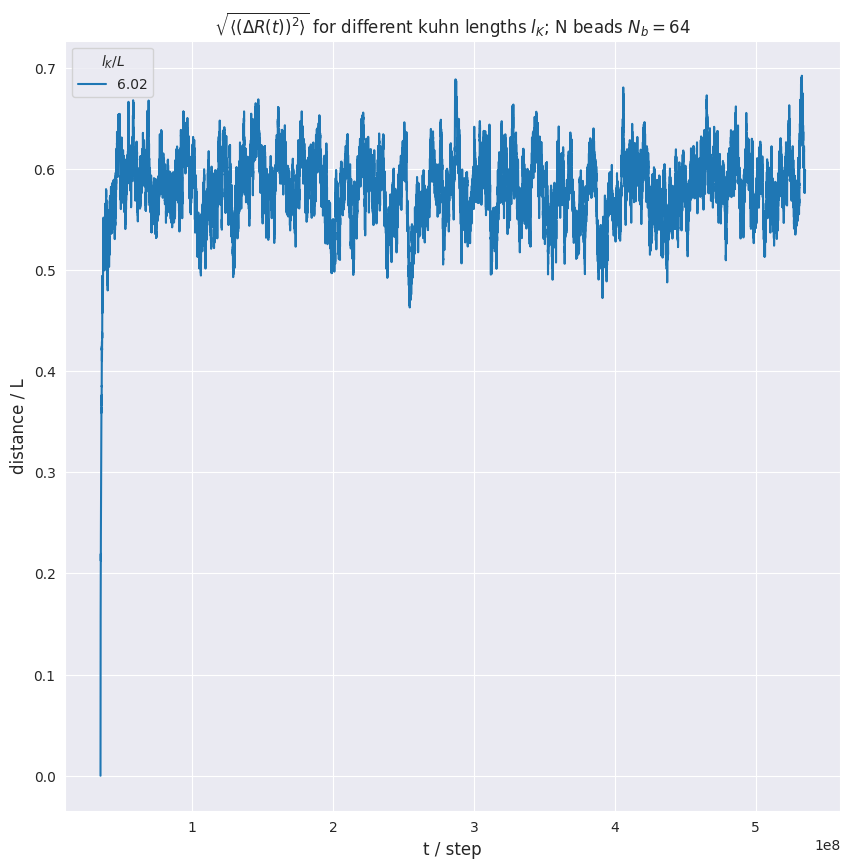

In [86]:
ax: plt.Axes
fig: plt.Figure
fig, ax = plt.subplots(figsize=(10,10))
ax.set(
    title=f'$ \sqrt {{\langle (\Delta R(t))^2 \\rangle}} $ for different kuhn lengths $l_K$; '
          f'N beads $N_b={conf.initial_system_config.system_config.n_monomers}$',
    ylabel="distance / L",
    xlabel="t / step"
)

sns.lineplot(
    x=df_ete_change_kappas_equi.index.get_level_values("t"),
    y=np.sqrt(df_ete_change_kappas_equi["dR^2"]) / L_contour,
    hue=(df_ete_change_kappas_equi["l_K"]/L_contour).round(2).astype("category"),
    color=kappa_colors,
    ax=ax
)

ax.get_legend().set_title("$l_K/L$")

## Compare with Grill

### Loglog scale

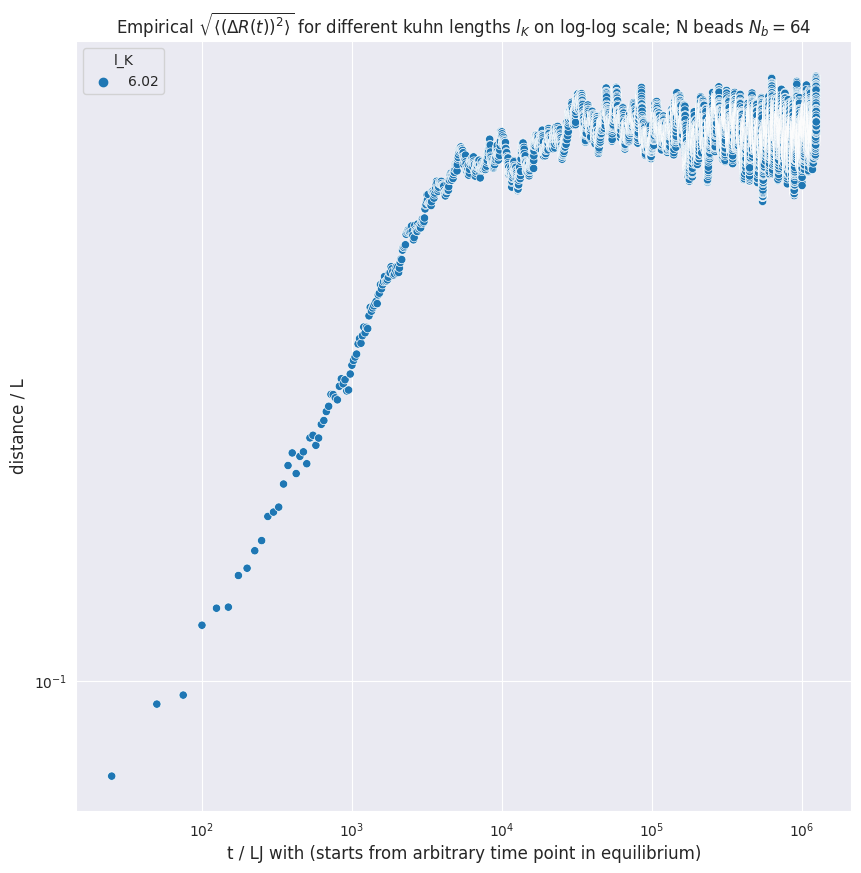

In [90]:
import matplotlib.ticker

ax: plt.Axes
fig: plt.Figure
fig, ax = plt.subplots(figsize=(10,10))

plot = sns.scatterplot(
    x=df_ete_change_kappas_equi["t/LJ"],
    y=np.sqrt(df_ete_change_kappas_equi["dR^2"]) / L_contour,
    hue=(df_ete_change_kappas_equi["l_K"]/L_contour).round(2).astype("category"),
    color=kappa_colors,
    style=(df_ete_change_kappas_equi["l_K"]/L_contour).round(2).astype("category"),
    ax=ax
)

_ = ax.set(
    yscale="log",
    xscale="log",
    title=f'Empirical $ \sqrt {{\langle (\Delta R(t))^2 \\rangle}} $ for different kuhn lengths $l_K$ on log-log scale; '
          f'N beads $N_b={conf.initial_system_config.system_config.n_monomers}$',
    ylabel="distance / L",
    xlabel="t / LJ with (starts from arbitrary time point in equilibrium)"
)


## Compare with Rouse model


### Analytical $\tau_R$

Svaneborg (15)

Rouse relaxation time:
$$ \tau_R = \frac{1}{3 \pi^2} \frac{\zeta_K N_K l_K^2}{k_B T} = \frac{1}{3 \pi^2} \frac{\zeta N_b N_K l_K^2}{k_B T}$$
Relaxation time of single bead:
$$ \tau_0 = \frac{3 \pi^2 \tau_R}{N_K^2} $$

In [92]:
zeta = 1  # LJ
T = 1
k_B = 1
alpha = 4.047

rouse_times_analytical = []
for i, (l_K, N_K, R_sq) in enumerate(zip(df_kuhn_summary["l_K"], df_kuhn_summary["N_K"], df_kuhn_summary["R^2"])):
    tau_R_analytical = zeta*conf.initial_system_config.system_config.n_monomers*N_K*l_K**2 / (3*np.pi**2*k_B*T)
    tau_R_analytical_corrected = tau_R_analytical*alpha
    rouse_times_analytical.append(tau_R_analytical_corrected)

df_rouse_times_theory = pd.DataFrame({
    "l_K": df_kuhn_summary["l_K"],
    "N_K": df_kuhn_summary["N_K"],
    "Theory tau_R": rouse_times_analytical,
    "Theory tau_0": rouse_times_analytical / df_kuhn_summary["N_K"]**2
}, index=df_kuhn_summary.index)

df_rouse_times_theory

,l_K,N_K,Theory tau_R,Theory tau_0
kappa,,,,
190.2,368.018,0.166052,196731.327645,7.134887e+06


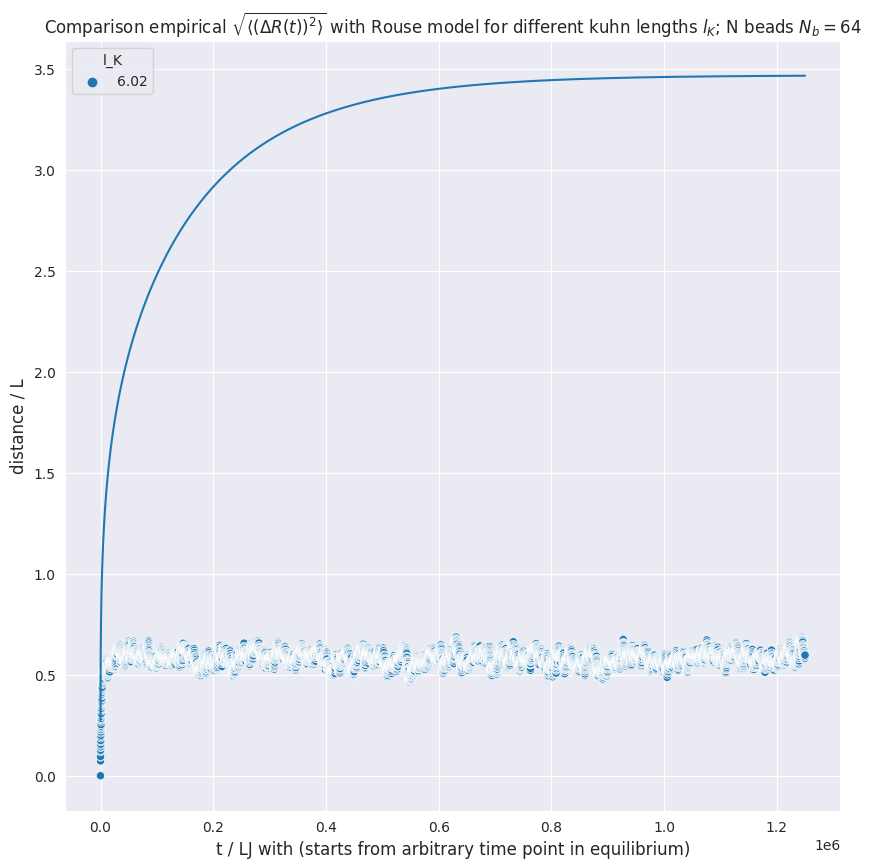

In [94]:
import matplotlib.legend

ax: plt.Axes
fig: plt.Figure
fig, ax = plt.subplots(figsize=(10,10))
ax.set(
    title=f'Comparison empirical $ \sqrt {{\langle (\Delta R(t))^2 \\rangle}} $ with Rouse model for different kuhn lengths $l_K$; '
          f'N beads $N_b={conf.initial_system_config.system_config.n_monomers}$',
    ylabel="distance / L",
    xlabel="t / LJ with (starts from arbitrary time point in equilibrium)"
)

plot = sns.scatterplot(
    x=df_ete_change_kappas_equi["t/LJ"],
    y=np.sqrt(df_ete_change_kappas_equi["dR^2"]) / L_contour,
    hue=(df_ete_change_kappas_equi["l_K"]/L_contour).round(2).astype("category"),
    color=kappa_colors,
    style=(df_ete_change_kappas_equi["l_K"]/L_contour).round(2).astype("category"),
    ax=ax
)

lines = []
labels = []

for i, (l_K, N_K, tau_R) in enumerate(zip(df_rouse_times_theory["l_K"], df_rouse_times_theory["N_K"], df_rouse_times_theory["Theory tau_R"])):
    ts = df_ete_change_kappas_equi["t/LJ"].unique()

    rouse_predictions = rouse.rouse_g_4(
        t=ts,
        tau_R=tau_R,
        p_max=conf.initial_system_config.system_config.n_monomers,
        N_b=N_K,
        l_b=l_K
    )
    line = ax.plot(
        ts,
        np.sqrt(rouse_predictions) / L_contour,
        color=kappa_colors[i]
    )
    lines.append(line)
    labels.append(f"$\sqrt{{g_4(t)}}$ for $l_K/L = {np.round(l_K/L_contour, 2)}$")

### Fit $\tau_R$

In [106]:

df_rouse_times_fit = []

for i, (kappa, df_ete_change_kappas_equi_kappa) in enumerate(df_ete_change_kappas_equi.groupby("kappa")):
    l_K = df_kuhn_summary.loc[kappa]["l_K"]
    N_K = df_kuhn_summary.loc[kappa]["N_K"]
    popt, pcov = scipy.optimize.curve_fit(
        functools.partial(rouse.rouse_g_4, N_b=N_K, l_b=l_K, p_max=conf.initial_system_config.system_config.n_monomers),
        df_ete_change_kappas_equi_kappa.loc[df_ete_change_kappas_equi_kappa["t/LJ"]<1e4]["t/LJ"],
        df_ete_change_kappas_equi_kappa[df_ete_change_kappas_equi_kappa["t/LJ"]<1e4]["dR^2"],
        p0=(10**(i+1),) if i!=0 else 100
    )
    df_rouse_times_fit.append((kappa, popt[0], np.sqrt(np.diag(pcov))[0], l_K, N_K))

df_rouse_times_fit = pd.DataFrame(
    df_rouse_times_fit,
    columns=["kappa", "Empirical tau_R", "Empirical Delta tau_R", "l_K", "N_K"]
).set_index("kappa")

df_rouse_times_fit["Empirical tau_0"] = df_rouse_times_fit["Empirical tau_R"] / df_rouse_times_fit["N_K"]**2
df_rouse_times_fit["Empirical Delta tau_0"] = df_rouse_times_fit["Empirical Delta tau_R"] / df_rouse_times_fit["N_K"]**2

df_rouse_times_fit

,Empirical tau_R,Empirical Delta tau_R,l_K,N_K,Empirical tau_0,Empirical Delta tau_0
kappa,,,,,,
190.2,6.864633e+06,89815.05141,368.018,0.166052,2.489607e+08,3.257337e+06


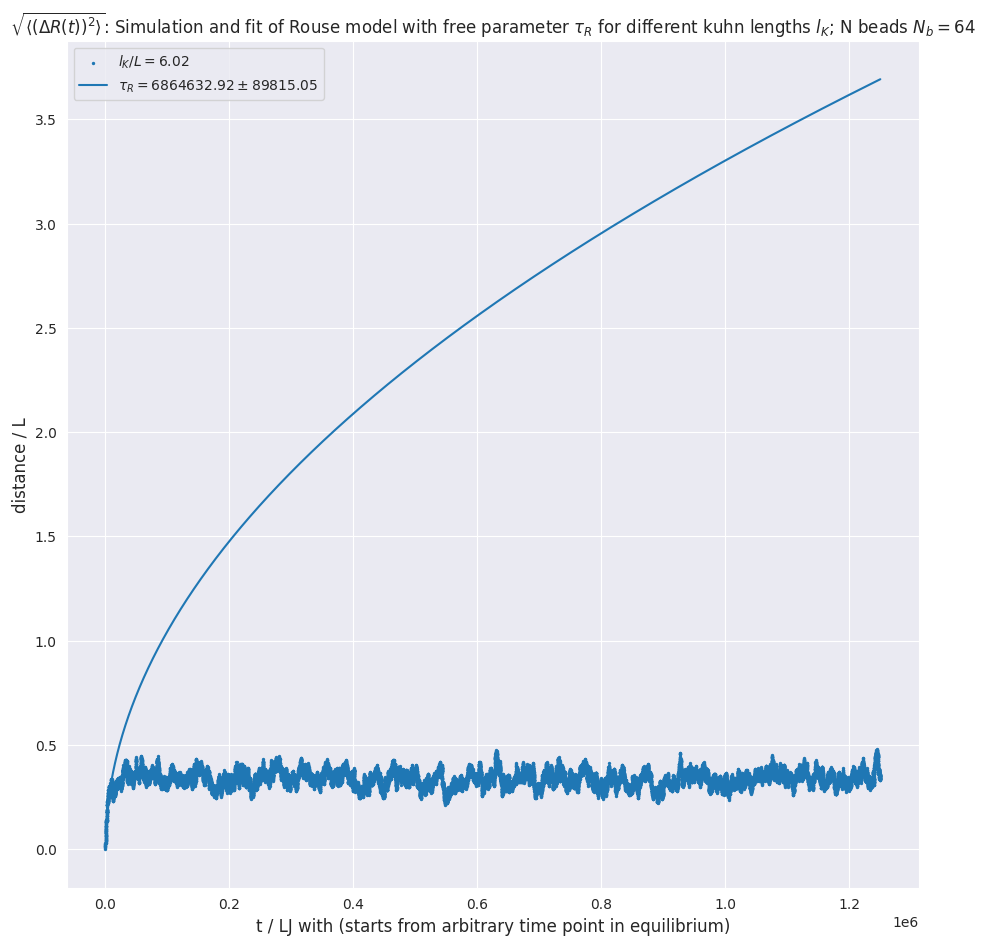

In [107]:
import matplotlib.markers

ax: plt.Axes
fig: plt.Figure
fig, ax = plt.subplots(figsize=(11,11))

for i, (kappa, df_ete_change_kappas_equi_kappa) in enumerate(df_ete_change_kappas_equi.groupby("kappa")):
    l_K = df_kuhn_summary.loc[kappa]["l_K"]
    N_K = df_kuhn_summary.loc[kappa]["N_K"]
    tau_R = df_rouse_times_fit.loc[kappa]["Empirical tau_R"]
    dtau_R = df_rouse_times_fit.loc[kappa]["Empirical Delta tau_R"]

    ax.scatter(
        df_ete_change_kappas_equi_kappa["t/LJ"],
        df_ete_change_kappas_equi_kappa["dR^2"] / L_contour**2,
        label=f"$l_K/L={np.round(l_K/L_contour, 2)}$",
        #marker= list(matplotlib.markers.MarkerStyle.markers.keys())[i],
        color=kappa_colors[i],
        s=2
    )
    ax.plot(
        df_ete_change_kappas_equi_kappa["t/LJ"],
        rouse.rouse_g_4(
            t=df_ete_change_kappas_equi_kappa["t/LJ"],
            N_b=N_K,
            l_b=l_K,
            p_max=conf.initial_system_config.system_config.n_monomers,
            tau_R=tau_R
        ) / L_contour**2,
        label=f"$\\tau_R={tau_R:.2f} \pm {dtau_R:.2f}$",
        color=kappa_colors[i]
    )

ax.legend()

_ = ax.set(
    title=f'$ \sqrt {{\langle (\Delta R(t))^2 \\rangle}} $: Simulation and fit of Rouse model with free parameter $\\tau_R$ for different kuhn lengths $l_K$; '
          f'N beads $N_b={conf.initial_system_config.system_config.n_monomers}$',
    ylabel="distance / L",
    xlabel="t / LJ with (starts from arbitrary time point in equilibrium)"
)

### Compare times

In [108]:
df_rouse_rimes = df_rouse_times_theory.join(df_rouse_times_fit.drop(["l_K", "N_K"], axis=1))
df_rouse_rimes

,l_K,N_K,Theory tau_R,Theory tau_0,Empirical tau_R,Empirical Delta tau_R,Empirical tau_0,Empirical Delta tau_0
kappa,,,,,,,,
190.2,368.018,0.166052,196731.327645,7.134887e+06,6.864633e+06,89815.05141,2.489607e+08,3.257337e+06


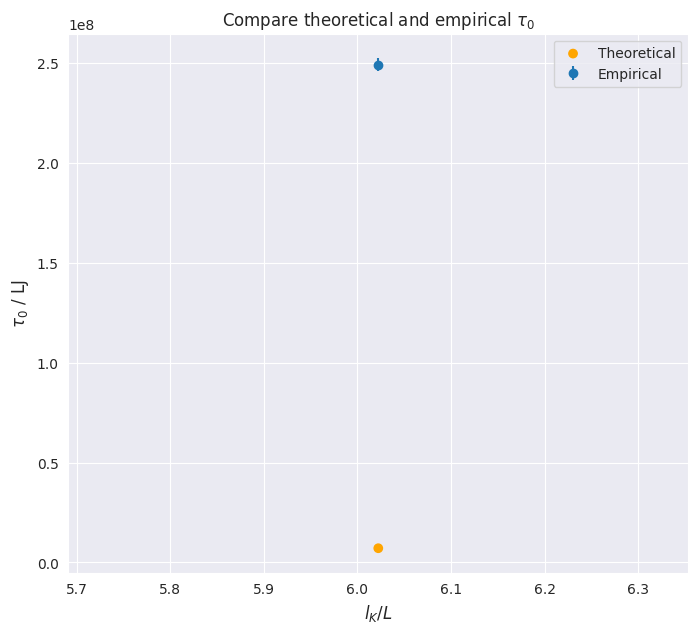

In [109]:
import matplotlib.container
import matplotlib.collections

ax: plt.Axes
fig: plt.Figure
fig, ax = plt.subplots(figsize=(8,7))

errorbar_container: matplotlib.container.ErrorbarContainer = ax.errorbar(
    x=df_rouse_rimes["l_K"] / L_contour,
    y=df_rouse_rimes["Empirical tau_0"],
    yerr=df_rouse_rimes["Empirical Delta tau_0"],
    linestyle="",
    marker="o",
    label="Empirical",
)

ax.set(
    xlabel="$l_K/L$",
    ylabel="$\\tau_0$ / LJ",
    title="Compare theoretical and empirical $\\tau_0$"
)

path_coll: matplotlib.collections.PathCollection = ax.scatter(
    x=df_rouse_rimes["l_K"] / L_contour,
    y=df_rouse_rimes["Theory tau_0"],
    linestyle="",
    marker="o",
    label="Theoretical",
    color="orange",
)

ax.legend()

[Text(0.5, 0, '$l_K/L$'),
 Text(0, 0.5, '$\\Delta \\tau_0$ / LJ'),
 Text(0.5, 1.0, 'Empirical $\\tau_0$ - Theoretical $\\tau_0$')]

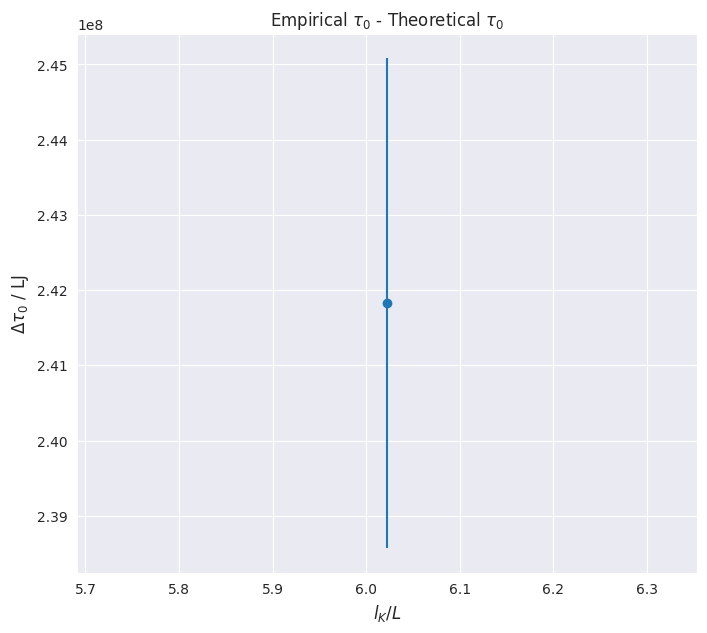

In [110]:
ax: plt.Axes
fig: plt.Figure
fig, ax = plt.subplots(figsize=(8,7))


errorbar_container: matplotlib.container.ErrorbarContainer = ax.errorbar(
    x=df_rouse_rimes["l_K"] / L_contour,
    y=df_rouse_rimes["Empirical tau_0"] - df_rouse_rimes["Theory tau_0"],
    yerr=df_rouse_rimes["Empirical Delta tau_0"],
    linestyle="",
    marker="o",
    label="Empirical - Theory",
)

ax.set(
    xlabel="$l_K/L$",
    ylabel="$\\Delta \\tau_0$ / LJ",
    title="Empirical $\\tau_0$ - Theoretical $\\tau_0$"
)